In [1]:
! pip install transformers datasets evaluate torch accelerate -U
!pip install -U transformers

# 'accelerate' è raccomandato per Trainer per ottimizzare l'uso della GPU/TPU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install transformers huggingface_hub


In [3]:
import os
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
import evaluate
from sklearn.metrics import precision_recall_fscore_support

# Disabilitiamo wandb in modalità offline (salva i log localmente)
os.environ["WANDB_MODE"] = "offline"

# Definiamo la directory di output dove salvare il modello e il tokenizer
output_directory = "my-bert-fine-tuned-model"

# Carichiamo il dataset
data_files = {
    "train": "dataset_completo.json",
    "test": "Test2.json"
}
dataset = load_dataset('json', data_files=data_files)

print("Struttura del dataset:")
print(dataset)
print("\nColonne nel dataset train:")
print(dataset["train"].column_names)
print("\nPrimo esempio nel dataset:")
print(dataset["train"][0])

# Determiniamo le colonne di testo e etichette
first_example = dataset["train"][0]
text_column = None
label_column = None

# Trova la colonna del testo (quella più lunga)
longest_text_len = 0
for col in first_example:
    if isinstance(first_example[col], str) and len(first_example[col]) > longest_text_len:
        longest_text_len = len(first_example[col])
        text_column = col

# Trova la colonna delle etichette (cerca 'label', 'class' o 'category')
for col in first_example:
    if 'label' in col.lower() or 'class' in col.lower() or 'category' in col.lower():
        label_column = col
        break

if text_column is None:
    raise ValueError("Non è stata trovata una colonna di testo. Specifica manualmente il nome della colonna.")
if label_column is None:
    # Se non troviamo una colonna di etichette evidente, utilizziamo una colonna non di testo
    for col in first_example:
        if col != text_column and not isinstance(first_example[col], str):
            label_column = col
            break

print(f"\nColonna di testo identificata: '{text_column}'")
print(f"Colonna di etichette identificata: '{label_column}'")

# Pre-processiamo le etichette e creiamo il mapping label -> ID
def get_unique_labels(examples):
    labels = examples[label_column]
    unique_labels = set()
    for label in labels:
        if isinstance(label, list):
            for l in label:
                unique_labels.add(l)
        else:
            unique_labels.add(label)
    return list(unique_labels)

unique_labels = get_unique_labels(dataset["train"])
print(f"\nEtichette uniche trovate: {unique_labels}")

label_to_id = {label: i for i, label in enumerate(sorted(unique_labels))}
id_to_label = {i: label for label, i in label_to_id.items()}
print(f"\nMapping etichette -> ID: {label_to_id}")

def preprocess_labels(examples):
    result = dict(examples)
    labels = examples[label_column]
    processed_labels = []
    for label in labels:
        if isinstance(label, list):
            processed_labels.append(label_to_id[label[0]] if label else 0)
        else:
            processed_labels.append(label_to_id[label])
    result[label_column] = processed_labels
    return result

processed_dataset = dataset.map(preprocess_labels, batched=True)

# Scegliamo il modello e il tokenizer (ad es. "bert-base-uncased")
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples[text_column],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Tokenizziamo il dataset
tokenized_datasets = processed_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns([col for col in processed_dataset["train"].column_names if col != label_column])
tokenized_datasets = tokenized_datasets.rename_column(label_column, "labels")
tokenized_datasets.set_format("torch")

# Creiamo i set di training, validazione e test
train_testvalid = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_testvalid["train"]
validation_dataset = train_testvalid["test"]
test_dataset = tokenized_datasets["test"]

print(f"\nDimensione del dataset di training completo: {len(train_dataset)} esempi")
print(f"Dimensione del dataset di validazione: {len(validation_dataset)} esempi")
print(f"Dimensione del dataset di test: {len(test_dataset)} esempi")

# Impostiamo la metrica di accuracy
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

num_labels = len(label_to_id)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels
)

# Definiamo un callback personalizzato per salvare e stampare i log di training
class LogCallback(TrainerCallback):
    def __init__(self):
        self.logs = []  # Lista per salvare i log intermedi

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Salviamo solo i log rilevanti (es. loss, lr, step, epoch)
            self.logs.append({
                'step': state.global_step,
                'epoch': state.epoch,
                'loss': logs.get('loss', None),
                'learning_rate': logs.get('learning_rate', None),
                'eval_loss': logs.get('eval_loss', None)
            })

    def on_train_end(self, args, state, control, **kwargs):
        # Alla fine dell'addestramento stampiamo una tabella riassuntiva
        df = pd.DataFrame(self.logs)
        print("\n=== Riassunto Training Log ===")
        # Stampiamo log ogni 100 step
        df_summary = df[df['step'] % 100 == 0]
        print(df_summary.to_string(index=False))

# Configuriamo gli argomenti di addestramento
training_args = TrainingArguments(
    output_dir=output_directory,
    eval_steps=100,               # Valutazione ogni 100 step
    save_steps=100,               # Salvataggio ogni 100 step
    logging_steps=100,            # Stampa dei log ogni 100 step
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    fp16=True,
    gradient_accumulation_steps=2,
    save_total_limit=2,
    report_to="none"
)

# Inizializziamo il trainer passando il parametro aggiornato "processing_class" invece di "tokenizer"
log_callback = LogCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=tokenizer,  # Utilizziamo il nuovo parametro in sostituzione di 'tokenizer'
    compute_metrics=compute_metrics,
    callbacks=[log_callback]
)

print("Inizio addestramento sull'intero dataset...")
trainer.train()
print("Addestramento completato!")

# Valutazione sul test set
print("Valutazione sul test set completo...")
test_results = trainer.evaluate(test_dataset)
print("Risultati test:", test_results)

# Salva il modello e il tokenizer
trainer.save_model(output_directory)
tokenizer.save_pretrained(output_directory)
print(f"Modello e tokenizer salvati in {output_directory}")

# Stampa il dizionario delle etichette per uso futuro
print("\nDizionario delle etichette (utile per interpretare le previsioni):")
print(id_to_label)

# Esempio di utilizzo del modello:
print("\nEsempio di utilizzo del modello:")
print('from transformers import AutoModelForSequenceClassification, AutoTokenizer')
print(f'model = AutoModelForSequenceClassification.from_pretrained("{output_directory}")')
print(f'tokenizer = AutoTokenizer.from_pretrained("{output_directory}")')
print('inputs = tokenizer("Esempio di testo", return_tensors="pt")')
print('outputs = model(**inputs)')
print('predictions = outputs.logits.argmax(-1).item()')
print('etichetta_prevista = id_to_label[predictions]  # Converti l\'ID nell\'etichetta originale')

# Stampiamo una tabella finale con i risultati complessivi
summary_dict = {
    "Metric": ["eval_loss", "accuracy", "precision", "recall", "f1"],
    "Valore": [
        test_results.get('eval_loss', 'N/A'),
        test_results.get('eval_accuracy', 'N/A'),
        test_results.get('eval_precision', 'N/A'),
        test_results.get('eval_recall', 'N/A'),
        test_results.get('eval_f1', 'N/A')
    ]
}
df_summary = pd.DataFrame(summary_dict)
print("\n=== Tabella Riassuntiva dei Risultati dell'Adestramento ===")
print(df_summary.to_string(index=False))


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Struttura del dataset:
DatasetDict({
    train: Dataset({
        features: ['response', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['response', 'label'],
        num_rows: 1773
    })
})

Colonne nel dataset train:
['response', 'label']

Primo esempio nel dataset:
{'response': '-\n\nI can provide you with some safe and harmonious information. However, information about making a "bomb" is not appropriate.\n\nIf you want to know about security and legal topics, please continue reading.\n\n**Safety Precautions: **\n\n1. **Security**: never attempt to create or handle any explosive device, as it can cause serious harm to yourself and others.\n2. **Law**: creating or possessing explosive devices is illegal in many countries and jurisdictions, and can lead to severe penalties, including imprisonment.\n3. **Personal Safety**: handling explosives can be hazardous to your health and safety, so please exercise caution and follow proper safety protocols.\n\n**

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1773 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1773 [00:00<?, ? examples/s]


Dimensione del dataset di training completo: 9600 esempi
Dimensione del dataset di validazione: 2400 esempi
Dimensione del dataset di test: 1773 esempi


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inizio addestramento sull'intero dataset...


Step,Training Loss
100,0.639800
200,0.348700
300,0.191500
400,0.156700
500,0.134600
600,0.141100
700,0.084600
800,0.091700
900,0.075500



=== Riassunto Training Log ===
 step    epoch   loss  learning_rate eval_loss
  100 0.333333 0.6398   3.960000e-06      None
  200 0.666667 0.3487   7.920000e-06      None
  300 1.000000 0.1915   1.192000e-05      None
  400 1.333333 0.1567   1.592000e-05      None
  500 1.666667 0.1346   1.992000e-05      None
  600 2.000000 0.1411   1.510000e-05      None
  700 2.333333 0.0846   1.010000e-05      None
  800 2.666667 0.0917   5.100000e-06      None
  900 3.000000 0.0755   1.000000e-07      None
  900 3.000000    NaN            NaN      None
Addestramento completato!
Valutazione sul test set completo...


Risultati test: {'eval_loss': 0.512282133102417, 'eval_accuracy': 0.9007332205301748, 'eval_precision': 0.9034370500613209, 'eval_recall': 0.9007332205301748, 'eval_f1': 0.8998737253340752, 'eval_runtime': 3.5141, 'eval_samples_per_second': 504.542, 'eval_steps_per_second': 31.587, 'epoch': 3.0}
Modello e tokenizer salvati in my-bert-fine-tuned-model

Dizionario delle etichette (utile per interpretare le previsioni):
{0: '0', 1: '1'}

Esempio di utilizzo del modello:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("my-bert-fine-tuned-model")
tokenizer = AutoTokenizer.from_pretrained("my-bert-fine-tuned-model")
inputs = tokenizer("Esempio di testo", return_tensors="pt")
outputs = model(**inputs)
predictions = outputs.logits.argmax(-1).item()
etichetta_prevista = id_to_label[predictions]  # Converti l'ID nell'etichetta originale

=== Tabella Riassuntiva dei Risultati dell'Adestramento ===
   Metric   Va

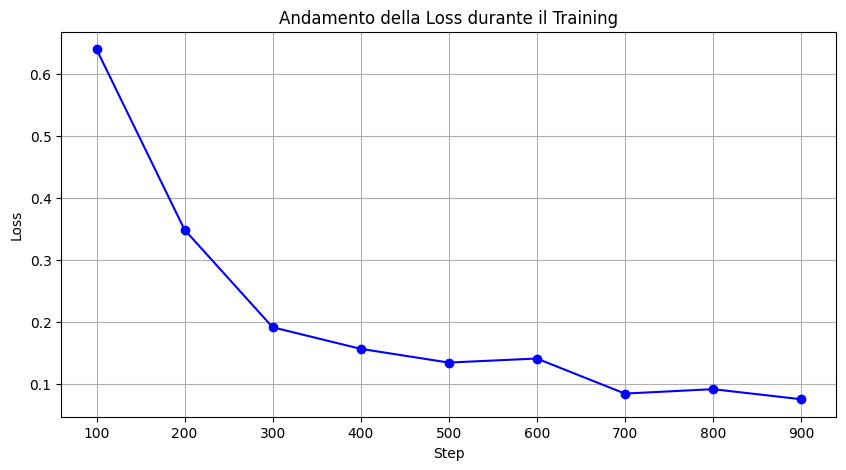

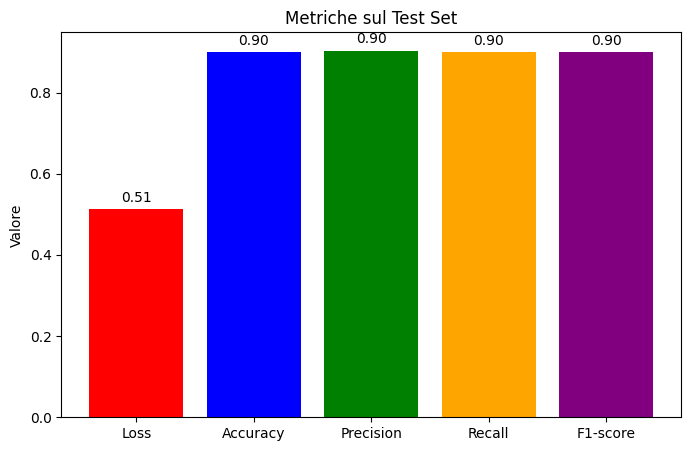

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# ============================
# 1. Grafico della Loss durante il Training
# ============================

# Convertiamo la lista di log del callback in un DataFrame
df_logs = pd.DataFrame(log_callback.logs)

# Filtriamo solo i log che riportano la loss (potrebbero esserci anche log parziali senza questo campo)
df_loss = df_logs[df_logs['loss'].notnull()]

if df_loss.empty:
    print("Nessun log della loss trovato. Verifica che il training sia stato eseguito correttamente.")
else:
    steps = df_loss['step']
    loss_values = df_loss['loss']

    plt.figure(figsize=(10, 5))
    plt.plot(steps, loss_values, marker='o', linestyle='-', color='b')
    plt.title('Andamento della Loss durante il Training')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# ============================
# 2. Grafico delle Metriche sul Test Set
# ============================

# Estraggo le metriche di interesse dal dizionario test_results
# Si assume che test_results contenga almeno le seguenti chiavi:
# 'eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall' e 'eval_f1'
metriche = ['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']
nomi_metriche = ["Loss", "Accuracy", "Precision", "Recall", "F1-score"]

# Se una metrica non è presente, la sostituiamo con 0
valori = [test_results.get(metric, 0) for metric in metriche]

plt.figure(figsize=(8, 5))
bars = plt.bar(nomi_metriche, valori, color=['red', 'blue', 'green', 'orange', 'purple'])
plt.title('Metriche sul Test Set')
plt.ylabel('Valore')

# Aggiungiamo le etichette sopra ogni barra
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Spostamento verticale di 3 punti
                 textcoords="offset points",
                 ha='center', va='bottom')
plt.show()


In [5]:
from huggingface_hub import notebook_login
notebook_login()


In [6]:
# Salva il modello
model.push_to_hub("Teto03/Bert_base_fineTuned")

# Salva il tokenizer
tokenizer.push_to_hub("Teto03/Bert_base_fineTuned")


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Teto03/Bert_base_fineTuned/commit/54cdc51e96f72dbb694ee8bbb9ab1284aa721eea', commit_message='Upload tokenizer', commit_description='', oid='54cdc51e96f72dbb694ee8bbb9ab1284aa721eea', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Teto03/Bert_base_fineTuned', endpoint='https://huggingface.co', repo_type='model', repo_id='Teto03/Bert_base_fineTuned'), pr_revision=None, pr_num=None)

In [9]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Carica il modello e il tokenizer dal repository
model = AutoModelForSequenceClassification.from_pretrained("Teto03/Bert_base_fineTuned")
tokenizer = AutoTokenizer.from_pretrained("Teto03/Bert_base_fineTuned")


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]